In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.generators.degree_seq import random_degree_sequence_graph
from networkx.algorithms.graphical import is_graphical
from networkx.utils.random_sequence import powerlaw_sequence
import matplotlib.pyplot as plt
plt.style.use('../figures/norm.mplstyle')
from ldpc.code_util import *
from ldpc.mod2 import *
from bposd.hgp import hgp
from bposd.css import css_code, compute_code_distance
import sys, os
from timeit import default_timer as timer
import cairo
import cmath

### Code generation

In [9]:
def shs_squarelattice_basegraph(L, save=False):
    pc = np.zeros((L, L, L, L), dtype=int) # adjacency matrix
    for i in range(L):
        for j in range(L):
            pc[i, j, (i+1)%L, j] = 1
            pc[i, j, (i-1)%L, j] = 1
            pc[i, j, i, (j+1)%L] = 1
            pc[i, j, i, (j-1)%L] = 1
            pc[(i+1)%L, j, i, j] = 1
            pc[(i-1)%L, j, i, j] = 1
            pc[i, (j+1)%L, i, j] = 1
            pc[i, (j-1)%L, i, j] = 1
    pc = pc.reshape(L**2, L**2)
    if save:
        savedir = savedir = '/Users/yitan/Library/CloudStorage/GoogleDrive-yitan@g.harvard.edu/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
        savename = f'hclassical_shs_squarelattice_L={L}.txt'
        np.savetxt(os.path.join(savedir, savename), pc, fmt='%d')
    return pc

h = shs_squarelattice_basegraph(20, save=True)

### No confinement plot

#### Computing from scratch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


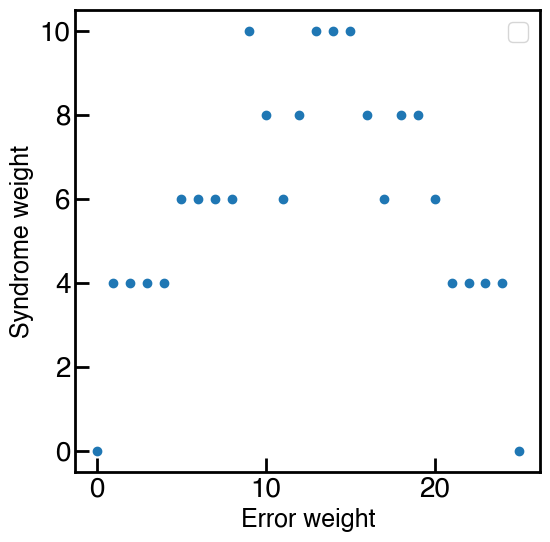

In [15]:
L = 10
# readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readdir = '/Users/yitan/Library/CloudStorage/GoogleDrive-yitan@g.harvard.edu/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readname = f'hclassical_shs_squarelattice_L={L}.txt'
h = np.loadtxt(os.path.join(readdir, readname))
# h = shs_squarelattice_basegraph(L)
logical_basis = nullspace(h)
logical_op = logical_basis[5]
logical_op_posones = np.where(logical_op==1)[0]
wte_min, wte_max = 0, np.sum(logical_op)
rng = np.random.default_rng(0)

nsamples = 1000
error_weights = np.arange(wte_min, wte_max+1, 1)
synd_weights_list = []
for error_weight in error_weights:
    error_vecs = np.zeros((nsamples, L**2), dtype=int)
    for i in range(nsamples):
        posones = rng.choice(logical_op_posones, size=error_weight, replace=False)
        error_vecs[i, posones] = 1
    synd_vecs = np.mod(error_vecs@(h.T), 2)
    synd_weights = np.sum(synd_vecs, axis=1)
    synd_weights_list.append(synd_weights)
synd_weights_min = np.min(synd_weights_list, axis=1)
np.save(os.path.join(readdir, f'synd_weights_min_L={L}_test.npy'), synd_weights_min)

fig, ax = plt.subplots()
ax.scatter(error_weights, synd_weights_min)
ax.set_xlabel('Error weight')
ax.set_ylabel('Syndrome weight')
ax.legend()
fig.set_size_inches(6, 6)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


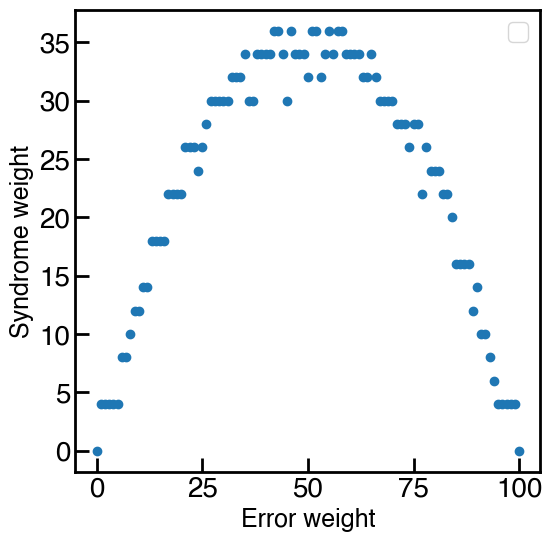

In [10]:
L = 20
# readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readdir = '/Users/yitan/Library/CloudStorage/GoogleDrive-yitan@g.harvard.edu/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readname = f'hclassical_shs_squarelattice_L={L}.txt'
h = np.loadtxt(os.path.join(readdir, readname))
# h = shs_squarelattice_basegraph(L)
logical_basis = nullspace(h)
logical_op = logical_basis[5]
logical_op_posones = np.where(logical_op==1)[0]
wte_min, wte_max = 0, np.sum(logical_op)
rng = np.random.default_rng(0)

nsamples = 500000
error_weights = np.arange(wte_min, wte_max+1, 1)
synd_weights_list = []
for error_weight in error_weights:
    error_vecs = np.zeros((nsamples, L**2), dtype=int)
    for i in range(nsamples):
        posones = rng.choice(logical_op_posones, size=error_weight, replace=False)
        error_vecs[i, posones] = 1
    synd_vecs = np.mod(error_vecs@(h.T), 2)
    synd_weights = np.sum(synd_vecs, axis=1)
    synd_weights_list.append(synd_weights)
synd_weights_min = np.min(synd_weights_list, axis=1)
np.save(os.path.join(readdir, f'synd_weights_min_L={L}.npy'), synd_weights_min)

fig, ax = plt.subplots()
ax.scatter(error_weights, synd_weights_min)
ax.set_xlabel('Error weight')
ax.set_ylabel('Syndrome weight')
ax.legend()
fig.set_size_inches(6, 6)
plt.show()

#### Load computed data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


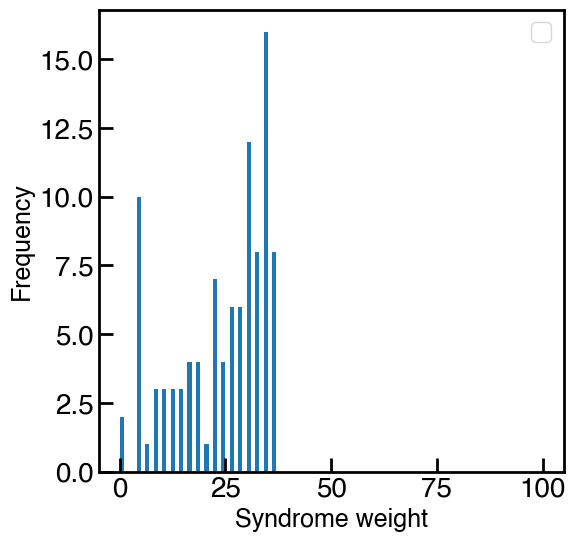

In [13]:
synd_weights_min = np.load(os.path.join(readdir, f'synd_weights_min_L={L}.npy'))
fig, ax = plt.subplots()
ax.hist(synd_weights_min, bins=error_weights)
ax.set_xlabel('Syndrome weight')
ax.set_ylabel('Frequency')
ax.legend()
fig.set_size_inches(6, 6)
plt.show()

### Visualize the logical opertaor

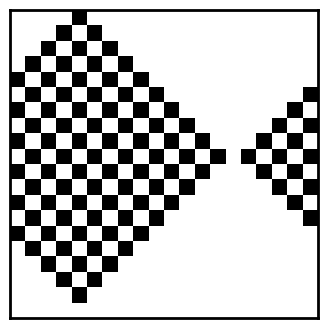

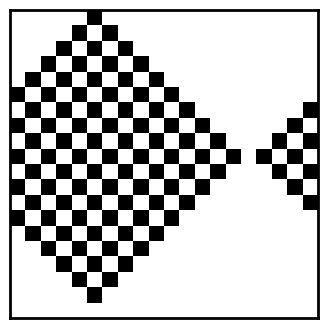

In [12]:
L = 20
readdir = '/Users/yitan/Library/CloudStorage/GoogleDrive-yitan@g.harvard.edu/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readname = f'hclassical_shs_squarelattice_L={L}.txt'
h = np.loadtxt(os.path.join(readdir, readname))

logical_basis = nullspace(h)

for i, logical_op in enumerate(logical_basis[4:6]):  # logical operator 4 and 5 are the nicely looking ones
    # plot the logical operator
    # random_error = np.zeros((L**2,), dtype=int)
    logical_visualize = logical_op.reshape((L, L))
    excitation_visualize = (h@logical_op % 2).reshape((L, L))
    fig, ax = plt.subplots()
    ax.imshow(logical_visualize, cmap='gray_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.show()